<a href="https://colab.research.google.com/github/colaquafina/Roller-King/blob/main/decoding_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
sns.set_context('poster')

from glob import glob

from sklearn import linear_model # linear - GLM
from sklearn.svm import LinearSVC # linear SVM classifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit,cross_validate

# Load data

In [5]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

if not os.path.exists('Roller-King'):
    !git clone https://github.com/colaquafina/Roller-King.git

# Load manual labels

In [6]:
for item in np.sort(glob('Roller-King/judge_*.npy')):
    print(item.split('/')[-1],np.load(item).shape)

judge_1.npy (440,)
judge_2.npy (440,)
judge_3.npy (440,)
judge_4.npy (430,)


# Combine the manually labeled labels to an array (n_samples,)

In [7]:
manual_labels = np.concatenate([np.load(item) for item in np.sort(glob('Roller-King/judge_*.npy'))])

# Checking the number of voxels of each ROI

In [8]:
unique_roi_index = np.unique(dat['roi'])
unique_roi_names = ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V4', 'Laterial occipital']
for idx,name in zip(unique_roi_index,unique_roi_names):
    print(name,np.sum(dat['roi'] == idx))

V1 1294
V2 2083
V3 1790
V3A 484
V3B 314
V4 1535
Laterial occipital 928


In [9]:
#?make_pipeline()

# Define a function for the decoding pipeline/workflow

In [10]:
def decoding_pipeline(BOLD_signal_voxels,
                      manual_labels,
                      the_model,
                      cv_method,
                      n_splits = 100,
                      **kwarg_cv):
    """
    BOLD_signal_voxels: (n_samples,n_features), the BOLD signals/voxel values
    manual_labels: (n_samples,), the labels that were manually labeled
    the_model: sklearn.pipeline or sklearn.object models, whichever contains methods of .fit and .predict
    cv_method: sklearn.model_selection objects, the cross validation spliter
    n_splits: int, the number of cross validation folds. The higher number of CV folds, the longer time it takes for running
    **kwarg_cv: dict, extra parameters of the cross validation method function
    """
    cv = cv_method(n_splits = n_splits,**kwarg_cv)
    decoding_results = cross_validate(the_model,
                                      BOLD_signal_voxels,
                                      manual_labels,
                                      groups = None,
                                      scoring = 'roc_auc',#什么意思？ # https://en.wikipedia.org/wiki/Receiver_operating_characteristic
                                      cv = cv,
                                      n_jobs = -1,
                                      return_estimator = True,
                                      verbose = 1,
                                      )
    return decoding_results#得到的是什么？ 得到一dictionary的变量，里面包含拟合的方程和每一次cross-validation的测试结果

# Now run the decoding pipeline for various size of the brain

In [11]:
results = dict()
# decode using all the voxels
## this is a GLM - logistic
#the_model = make_pipeline(StandardScaler(),
#                          linear_model.LogisticRegression(class_weight = 'balanced',
#                                                          random_state = 12345,
#                                                          ))
## this is an SVM - linear SVM
the_model = make_pipeline(StandardScaler(),
                          LinearSVC(penalty = 'l1', # not default
                                    loss = 'squared_hinge',
                                    dual = False, # not default, it has to be False for L1 penalty
                                    tol = 1e-4,
                                    C = 1.,
                                    class_weight = 'balanced',
                                    random_state = 12345,
                                    ))
cv = StratifiedShuffleSplit
res = decoding_pipeline(dat['responses'],
                        manual_labels,
                        the_model = the_model,
                        cv_method = cv,
                        n_splits = 50,
                        **dict(test_size = 0.2,
                               random_state = 12345),
                        )
results['All'] = res
for roi_name,idx_voxel in zip(unique_roi_names,unique_roi_index):
    voxel_selected = dat['responses'][:,dat['roi'] == idx_voxel]
    the_model = make_pipeline(StandardScaler(),
                              linear_model.LogisticRegression(class_weight = 'balanced',
                                                              random_state = 12345,
                                                              ))
    results[roi_name] = decoding_pipeline(voxel_selected,manual_labels,
                                          the_model = the_model,
                                          cv_method = cv,
                                          n_splits = 50,
                                          **dict(test_size = 0.2,
                                                 random_state = 12345),)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   39.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   33.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Don

In [12]:
df_plot = dict(roi_name = [],
               roc_auc = [],
               )
for roi_name,res in results.items():
    for score in res['test_score']:
        df_plot['roi_name'].append(roi_name)
        df_plot['roc_auc'].append(score)
df_plot = pd.DataFrame(df_plot)

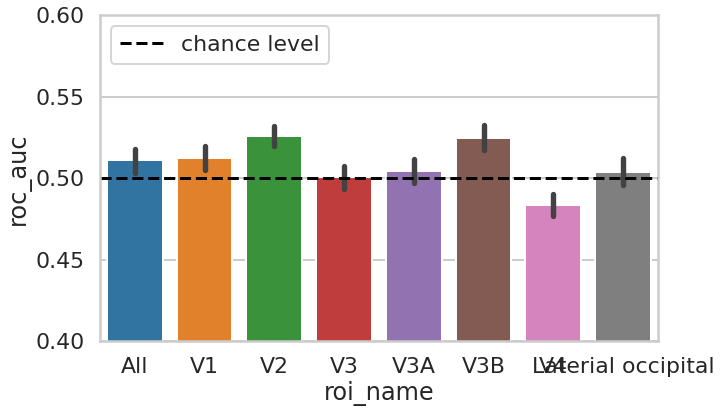

In [13]:
fig,ax = plt.subplots(figsize = (10,6))
ax = sns.barplot(x = 'roi_name',
                 y = 'roc_auc',
                 data = df_plot,
                 ax = ax,
                 )
ax.axhline(0.5, linestyle = '--',color = 'black',label = 'chance level')
ax.set(ylim = (0.4,0.6))
ax.legend(loc = 'upper left')

# representational similarity analysis

In [14]:
from scipy.spatial import distance

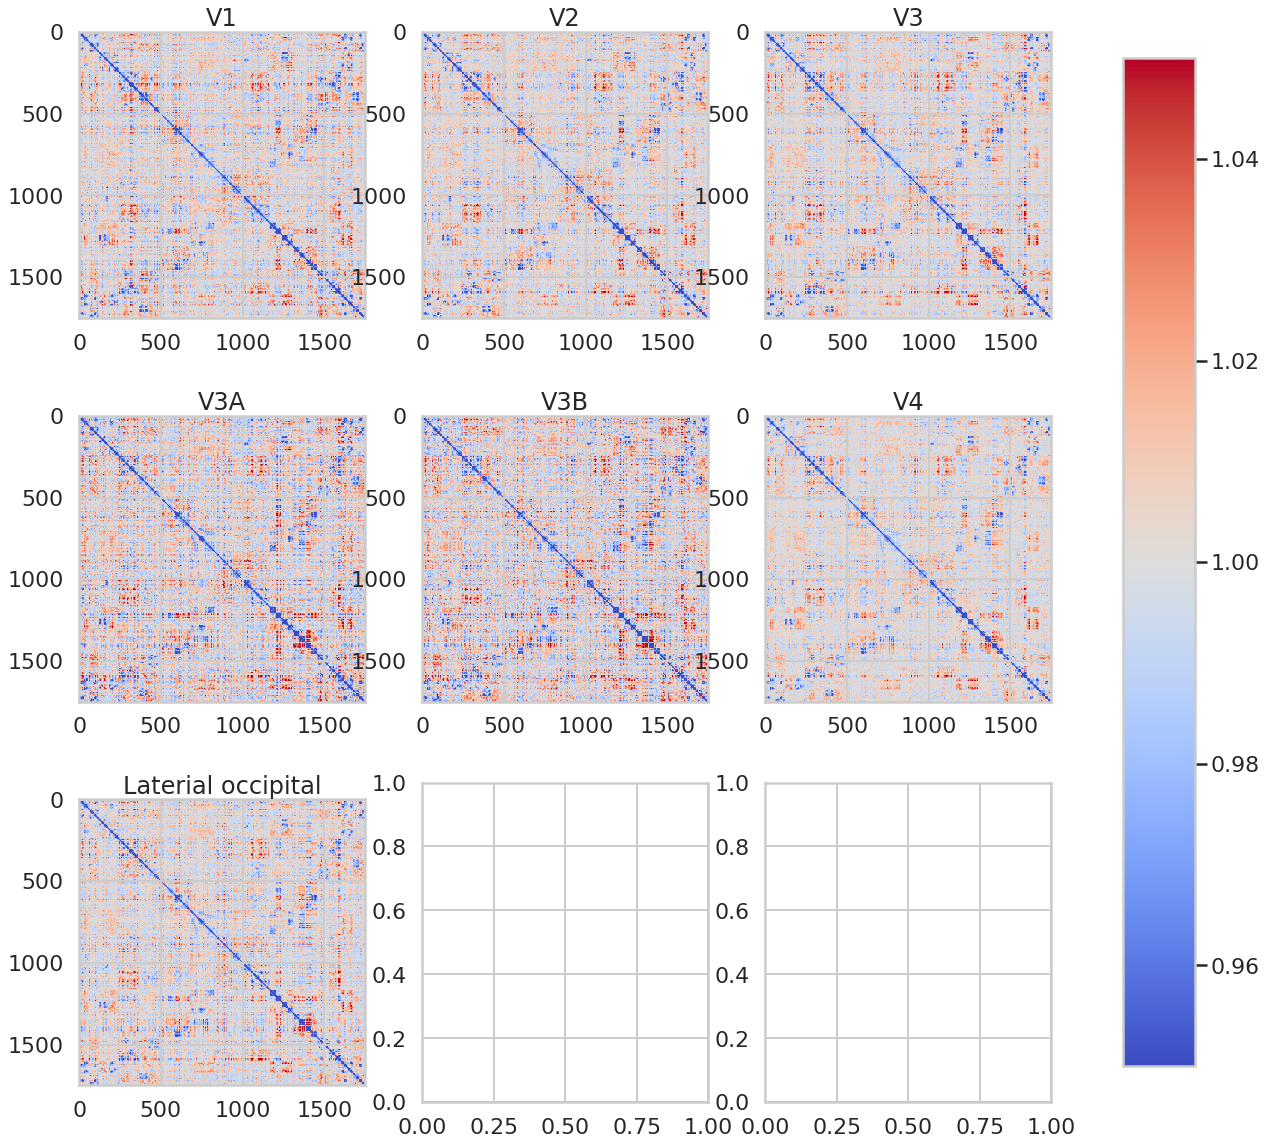

In [15]:
fig,axes = plt.subplots(figsize = (20,20,),
                        nrows = 3,
                        ncols = 3,
                        )
for roi_name,idx_voxel,ax in zip(unique_roi_names,unique_roi_index,axes.flatten()):
    voxel_selected = dat['responses'][:,dat['roi'] == idx_voxel]
    idx_sort = np.argsort(manual_labels)
    X = voxel_selected[idx_sort]
    y = manual_labels[idx_sort]
    RDM = distance.squareform(distance.pdist(X,metric = 'correlation'))
    im = ax.imshow(RDM,cmap = plt.cm.coolwarm,vmin = .95,vmax = 1.05)
    ax.set(title = roi_name)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)